# EXTRACTING UNIPROT FEATURE ANNOTATIONS TO CLASSIFY SITES BASED ON FUNCTION

### IMPORTING NECESSARY PACKAGES

In [2]:
from fragsys_analysis import *

## READING INPUT DATA

In [3]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [4]:
func_df = load_pickle(os.path.join(results_dir, "prot_func_dict_comb.pkl"))
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))

In [5]:
print(len(func_df))
print(len(rsa_cluster_dict))

293
293


In [6]:
func_df.head(3)

,bs_id,auto,manual,comb
0,H0Y4R8_0_BS0,UF,UF,UF
1,O15178_0_BS0,UF,UF,UF
2,O15178_0_BS1,UF,UF,UF


In [7]:
func_df["rsa_cluster"] = func_df.bs_id.map(rsa_cluster_dict)
func_df = func_df.query('rsa_cluster == rsa_cluster').reset_index(drop = True)
func_df.rsa_cluster = func_df.rsa_cluster.astype(int)

In [8]:
func_df.query('bs_id == "Q8WS26_0_BS4"')

,bs_id,auto,manual,comb,rsa_cluster
220,Q8WS26_0_BS4,UF,KF,KF,0


In [11]:
len(func_df.query('rsa_cluster == 0'))

46

In [10]:
len(func_df.query('rsa_cluster == 0 & comb == "KF"'))

17

In [9]:
len(func_df.query('rsa_cluster == 0 & comb == "UF"'))

29

### CALCULATING ENRICHMENT IN FUNCTION WITHIN CLUSTERS

In [20]:
c_labs = sorted(func_df.rsa_cluster.unique().tolist())
kf, uf = [[], []]
for c in c_labs:
    kf.append(len(func_df.query('rsa_cluster == @c and comb == "KF"')))
    uf.append(len(func_df.query('rsa_cluster == @c and comb == "UF"')))
cont_tab = pd.DataFrame(list(zip(kf, uf)), columns = ["kf", "uf"])
cont_tab.index = c_labs
cont_tab

,kf,uf
0,17,29
1,21,106
2,6,85
3,0,29


In [21]:
cont_tab.kf + cont_tab.uf

0     46
1    127
2     91
3     29
dtype: int64

In [22]:
cont_tab = cont_tab + 1
cont_tab["tot"] = cont_tab.kf + cont_tab.uf

In [24]:
cont_tab

,kf,uf,tot
0,18,30,48
1,22,107,129
2,7,86,93
3,1,30,31


In [25]:
cont_tab_or = get_OR(cont_tab, c_labs, "tot")

0 [18, 30, 48, 253]
1 [22, 26, 129, 172]
2 [7, 41, 93, 208]
3 [1, 47, 31, 270]


In [26]:
cont_tab_or

,kf,uf,tot,oddsratio,log_oddsratio,pvalue,ci_dist
0,18,30,48,3.16,1.15,0.00,0.66
1,22,107,129,1.13,0.12,0.75,0.61
2,7,86,93,0.38,-0.96,0.02,0.84
3,1,30,31,0.19,-1.69,0.10,2.02


In [13]:
print(round(3.16/1.13,2))
print(round(3.16/0.38,2))
print(round(3.16/0.19,2))

2.8
8.32
16.63


In [1]:
(2.8+8.3+16.6)/3

9.233333333333334

In [14]:
colss = sample_colors[:4]

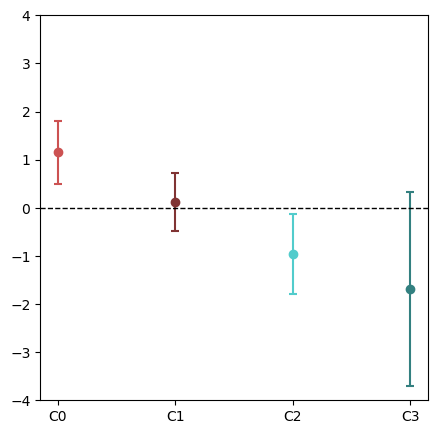

In [15]:
fig = plt.figure(figsize = (5, 5), dpi = 100)
for i, idx in enumerate(cont_tab_or.index.tolist()):
    plt.errorbar(
        c_labs[i], cont_tab_or.loc[idx, "log_oddsratio"], yerr = cont_tab_or.loc[idx, "ci_dist"],
        ecolor = colss[i], elinewidth = 1.5, capsize = 3, capthick = 1.5, fmt = "o", c = colss[i], ls = 'None'
    )
plt.ylim(-4, 4)
plt.axhline(y = 0, linestyle = "--", linewidth = 1, c = "black")
plt.xticks([0, 1, 2, 3], ["C0", "C1", "C2", "C3"])
#plt.savefig(os.path.join(figs_dir, "RSA_clusters_func.png"))
plt.show()